# Stepik ML Contest
Практическим проектом нашего [курса](https://stepik.org/course/4852/syllabus) будет анализ активности студентов онлайн курса "Введение в анализ данных в R".

Описание данных:
- [**events_train.csv**](https://stepik.org/media/attachments/course/4852/event_data_train.zip) - данные о действиях, которые совершают студенты со стэпами.
    1. step_id - id стэпа
    2. user_id - анонимизированный id юзера
    3. timestamp - время наступления события в формате unix date
    4. action - событие, возможные значения: 
        - discovered - пользователь перешел на стэп
        - viewed - просмотр шага,
        - started_attempt - начало попытки решить шаг, ранее нужно было явно нажать на кнопку - начать решение, перед тем как приступить к решению практического шага
        - passed - удачное решение практического шага. 
- [**submissions_train.csv**](https://stepik.org/media/attachments/course/4852/submissions_data_train.zip) - данные о времени и статусах сабмитов к практическим заданиям.
    1. step_id - id стэпа
    2. timestamp - время отправки решения в формате unix date
    3. submission_status - статус решения
    4. user_id - анонимизированный id юзера

### Мы будем считать, что пользователь успешно закончил курс, если он правильно решил больше 40 практических заданий.

В данных:
- [submission_data_test.csv](https://stepik.org/media/attachments/course/4852/submission_data_test.csv)
- [events_data_test.csv](https://stepik.org/media/attachments/course/4852/events_data_test.csv)

хранится информация о решениях и действиях для 6184 студентов за первые два дня прохождения курса. Это 6184 студентов, которые проходили курс в период с мая 2018 по январь 2019.

Используя данные о первых двух днях активности на курсе вам нужно предсказать, наберет ли пользователь более 40 баллов на курсе или нет.

В этих данных, вам доступны только первые дня активности студентов для того, чтобы сделать предсказание. На самом деле, используя эти данные, вы уже можете сделать прогноз. Например, если пользователь за первые два дня набрал 40 баллов, скорее всего он наберет более 40 баллов в дальнейшем. Чтобы подкрепить такие гипотезы, вы можете использовать данные, на которые мы исследовали в первых двух модулях курса, где для всех пользователей представлены все данные об их активности на курсе. 

## Соревнование начинается
<hr>

## 1. Построение baseline решения задачи.
Итак, у нас есть информация о том, какую активность проявляли пользователи за 2015-2018 года на курсе по "Введению в анализ данных на R" в виде датасета events_train. Также нам даны данные о попытках закрыть задачу в виде датафрейма submissions_train.
<br>Наша задача состоит в предсказании: пройдет ли студент курс на 40 баллов или же уйдет с курса (40 степов passed). Предсказать его поведение нужно за первые два дня, проведенные на курсе.

В первую очередь определим, **что значит, что студент ушел с курса?** В принципе, мы можем взять какое-то определенное число, например 1 месяц, но было бы неплохо, если бы мы выяснили это каким-то вещим образом. Можем посчитать 90 и 95 персентиль и посчитать их среднее.

Теперь выясним, **какие данные могут помочь нам провести анализ за первые 2 дня и сделать предсказание?**:
<br>На самом деле, не так много. Как бы круто не была устроена модель, будем ориентироваться на адекватные возможности уместить данные за первые два дня.
- В качестве переменных для **y** мы возьмем значение переменной *passed_course* - прошел ли студент курс (на 40+ баллов).
- В **Х** мы можем сложить:
    1. **user_id** - идентификаторы пользователя, как индексы.
    2. **unique_days** - Количество уникальных проведенных на курсе дней (за первые дня дня). Максимум - это три дня (т.к. двое суток могут охватить 3 дня). Таким образом можно выяснить, насколько активен пользователь был в первые дни на курсе.
    3. Количество совершенных действий каждого типа action. Как и для предыдущего пункта. Пользователь мог отвалиться на каком то этапе.
    4. Количество правильно и неправильно решенных степов, а также процентное соотношение правильных попыток ко всем попыткам. Эти данные могут помочь словить "сгоревших" пользователей.
    5. **steps_tried** - В целом, количество шагов, которые пользователь попробовал решить.

В принципе, только такие данные мы и можем синтезировать из наших датасетов. Правда можно еще взять и учесть последний попробованный степ, для каждого пользователя. Может быть мы сумеем обнаружить такой степ, на котором много людей отсеиваются.

## 2. Предобработка данных
Ключевые аналитические моменты мы выделили, теперь проведем предобработку данных, проанализируем датасеты на адекватность, и посчитаем данные об успеваемости пользователей за все время. Также не забываем обращать внимание на сохранность наших данных, чтобы мы не потеряли никаких нужных наблюдений и не убрали ничего лишнего.

Импортируем библиотеки и загрузим все данные.

In [520]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

events_data_train      = pd.read_csv("datasets/event_data_train.zip", compression="zip")
submissions_data_train = pd.read_csv("datasets/submissions_data_train.zip", compression="zip")

Взглянем на содержимое этих датасетов.

In [521]:
events_data_train

,step_id,timestamp,action,user_id
0,32815,1434340848,viewed,17632
1,32815,1434340848,passed,17632
2,32815,1434340848,discovered,17632
3,32811,1434340895,discovered,17632
4,32811,1434340895,viewed,17632
...,...,...,...,...
3480698,33375,1526772685,viewed,11677
3480699,32815,1526772750,viewed,5198
3480700,32815,1526772750,discovered,5198
3480701,32815,1526772750,passed,5198


In [522]:
events_data_train.action.unique()

array(['viewed', 'passed', 'discovered', 'started_attempt'], dtype=object)

In [523]:
submissions_data_train

,step_id,timestamp,submission_status,user_id
0,31971,1434349275,correct,15853
1,31972,1434348300,correct,15853
2,31972,1478852149,wrong,15853
3,31972,1478852164,correct,15853
4,31976,1434348123,wrong,15853
...,...,...,...,...
509099,120745,1501946959,wrong,2615
509100,120745,1503059927,correct,13177
509101,120745,1506348153,wrong,15253
509102,120745,1523035316,wrong,1424


In [524]:
submissions_data_train.submission_status.unique()

array(['correct', 'wrong'], dtype=object)

Из первичного анализа можем в целом представить, из чего состоят наши данные. Единственное, что я не понял - в чем разница между *discovered* и*viewed*. Вероятнее всего, каждый раз когда мы переходим на степ, например с предыдущего степа, при обновлении степа или просто когда мы по ссылке переходим на конкретный степ, мы производим *viewed*. Но самый первый *viewed* для каждого степа для каждого пользователя - это *discovered*. 

Т.е. по сути своей *viewed* >= *discovered*. Этот момент мы еще рассмотрим далее, а пока поработаем с датами и узнаем, за какой промежуток времени у нас есть данные.

In [525]:
events_data_train["date"] = pd.to_datetime(events_data_train.timestamp, unit="s")
submissions_data_train["date"] = pd.to_datetime(submissions_data_train.timestamp, unit="s")

events_data_train["day"] = events_data_train.date.dt.date
submissions_data_train["day"] = submissions_data_train.date.dt.date

In [526]:
events_data_train.head()

,step_id,timestamp,action,user_id,date,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15


In [527]:
submissions_data_train.head()

,step_id,timestamp,submission_status,user_id,date,day
0,31971,1434349275,correct,15853,2015-06-15 06:21:15,2015-06-15
1,31972,1434348300,correct,15853,2015-06-15 06:05:00,2015-06-15
2,31972,1478852149,wrong,15853,2016-11-11 08:15:49,2016-11-11
3,31972,1478852164,correct,15853,2016-11-11 08:16:04,2016-11-11
4,31976,1434348123,wrong,15853,2015-06-15 06:02:03,2015-06-15


In [528]:
print(f"Min event day: {events_data_train.day.min()}")
print(f"Max event day: {events_data_train.day.max()}")
print(f"Min submission day: {submissions_data_train.day.min()}")
print(f"Max submission day: {submissions_data_train.day.max()}")

Min event day: 2015-06-15
Max event day: 2018-05-19
Min submission day: 2015-06-15
Max submission day: 2018-05-19


Из данных выше видно, что у нас есть данные по июнь 2015 - май 2018. Неадекватных дат не обнаружено.

Взглянем на динамику активности пользователей по ходу времени. Активным в определенный день считаем того пользователя, кто совершил хоть одно действие за день.

In [529]:
action_dynamic = events_data_train\
    .groupby("day")\
    .user_id.nunique()\
    .to_frame()

action_dynamic

,user_id
day,
2015-06-15,705
2015-06-16,526
2015-06-17,440
2015-06-18,411
2015-06-19,377
...,...
2018-05-15,145
2018-05-16,155
2018-05-17,165


Text(0.5, 0, 'Месяц и год')

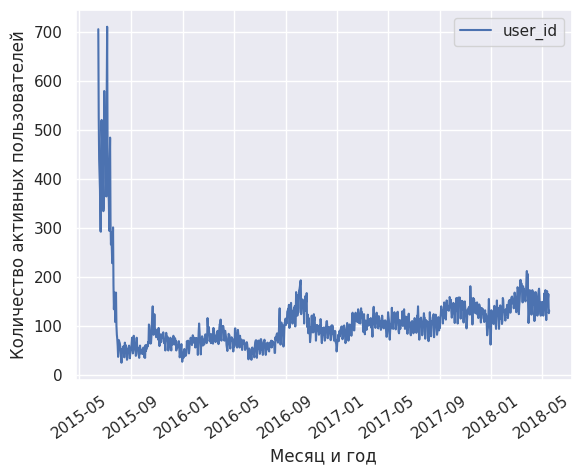

In [530]:
action_dynamic.plot().tick_params(axis="x", rotation=35)
plt.ylabel("Количество активных пользователей")
plt.xlabel("Месяц и год")

Получили то, что является весьма ожидаемым - высокая активность на старте и затем падение активности. После падения активности летом 2015 года с течением времени начинается постепенный прирост пользователей, ежедневно активничающих на курсе.

Взглянем на общее число пользователей и степов.

In [531]:
print(f'User amount: {events_data_train.user_id.nunique()}')
print(f'Steps amount: {events_data_train.step_id.nunique()}')

User amount: 19234
Steps amount: 198


Всего имеем **19234** пользователя и **198** степов. Количество пользователей необходимо будет контролировать в будущем для правильных слияний таблиц.

Теперь изучим, какие перерывы делали пользователи между днями активности.

In [532]:
gap_data = events_data_train[["user_id", "timestamp", "day"]]\
    .drop_duplicates(subset=["user_id", "day"])\
    .groupby("user_id")\
    .timestamp\
    .apply(list).apply(np.diff)\
    .values

gap_data

array([array([], dtype=int64), array([4843602]),
       array([6899249,  182484,   93710, 2768870,  171400,   78712]), ...,
       array([   86128,   136759,    94899,  1422583, 14347289,   505061,
                 98252,    57019])                                       ,
       array([1567990]), array([], dtype=int64)], dtype=object)

In [533]:
gap_data = pd.Series(np.concatenate(gap_data, axis=0))
gap_data = gap_data / (24 * 60 * 60)
gap_data

0         56.060208
1         79.852419
2          2.112083
3          1.084606
4         32.047106
            ...    
97867    166.056586
97868      5.845613
97869      1.137176
97870      0.659942
97871     18.148032
Length: 97872, dtype: float64

Взглянем на гистограмму распределения перерывов пользователей. Отбросим всех пользователей, чей перерыв превышает 1 год, т.к. этих пользователей явно можно отнести к тем, кто покинул курс.

<Axes: >

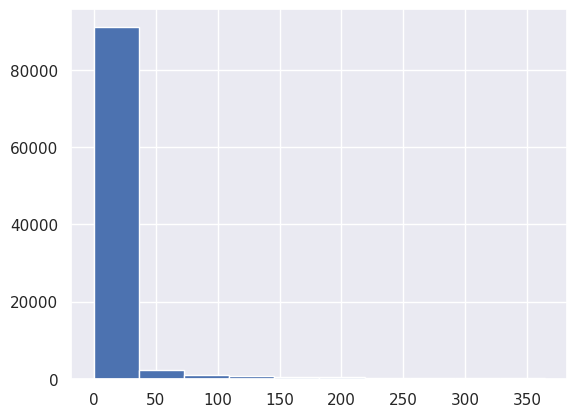

In [534]:
gap_data[gap_data < 365].hist()

Как мы можем заметить, подавляющее большинство перерывов в активности пользователя приходится до 50 дня.

In [535]:
print(f"90% quantile: {gap_data.quantile(0.90)}")
print(f"95% quantile: {gap_data.quantile(0.95)}")

90% quantile: 18.325995370370403
95% quantile: 59.760440972222156


90% перерывов между активностями приходятся вплоть до 18 дней. 95% - до 59 дней. В качестве ограничения количества дней, при котором мы можем сказать, что пользователь покинул курс, можем выбрать значение между этими двумя числами. Ради красоты выберем 30 дней.

In [536]:
drop_out_threshold = 30 * 24 * 60 * 60
drop_out_threshold

2592000

Теперь, когда мы чуточку получше изучили историю, прячущуюся за нашими данными, можем попробовать собрать данные о том, прошел ли пользователь курс (т.е. набрал >= 40 *passed*), либо покинул курс. Заведем новый датафрейм users_data, куда сложим полную информацию о пользователях.

In [537]:
users_data = events_data_train.pivot_table(
    index="user_id",
    columns="action",
    values="step_id",
    aggfunc="count",
    fill_value=0
).reset_index()

users_data

action,user_id,discovered,passed,started_attempt,viewed
0,1,1,0,0,1
1,2,9,9,2,10
2,3,91,87,30,192
3,5,11,11,4,12
4,7,1,1,0,1
...,...,...,...,...,...
19229,26790,8,8,1,9
19230,26793,1,0,1,1
19231,26794,69,69,34,180
19232,26797,10,10,2,13


Из столбца passed достанем информацию о том, прошел ли пользователь курс или нет.

In [538]:
users_data["passed_course"] = users_data.passed >= 40
users_data

action,user_id,discovered,passed,started_attempt,viewed,passed_course
0,1,1,0,0,1,False
1,2,9,9,2,10,False
2,3,91,87,30,192,True
3,5,11,11,4,12,False
4,7,1,1,0,1,False
...,...,...,...,...,...,...
19229,26790,8,8,1,9,False
19230,26793,1,0,1,1,False
19231,26794,69,69,34,180,True
19232,26797,10,10,2,13,False


Теперь проанализируем пользователей на факт ухода с курса. Для начала представим, что мы оказались в 2018 году и ведем отсчет до момента последней активности пользователя.

In [539]:
max_timestamp = events_data_train.timestamp.max()
max_timestamp

1526772811

Привяжем к нашей таблице пользователей столбец с последним таймстемпом активности для каждого пользователя.

In [540]:
users_last_timestamp = events_data_train\
    .groupby("user_id")\
    .timestamp.max()\
    .reset_index()\
    .rename(columns={"timestamp": "last_timestamp"})

users_last_timestamp

,user_id,last_timestamp
0,1,1472827464
1,2,1519226966
2,3,1444581588
3,5,1499859939
4,7,1521634660
...,...,...
19229,26790,1517495987
19230,26793,1510225034
19231,26794,1512035039
19232,26797,1509995096


In [541]:
users_data = users_data.merge(users_last_timestamp, how="outer", on="user_id")
users_data

,user_id,discovered,passed,started_attempt,viewed,passed_course,last_timestamp
0,1,1,0,0,1,False,1472827464
1,2,9,9,2,10,False,1519226966
2,3,91,87,30,192,True,1444581588
3,5,11,11,4,12,False,1499859939
4,7,1,1,0,1,False,1521634660
...,...,...,...,...,...,...,...
19229,26790,8,8,1,9,False,1517495987
19230,26793,1,0,1,1,False,1510225034
19231,26794,69,69,34,180,True,1512035039
19232,26797,10,10,2,13,False,1509995096


Добавим колонку с информацией о том, покинул ли пользователь курс или нет.

In [542]:
users_data["is_gone"] = (max_timestamp - users_data.last_timestamp) > drop_out_threshold
users_data

,user_id,discovered,passed,started_attempt,viewed,passed_course,last_timestamp,is_gone
0,1,1,0,0,1,False,1472827464,True
1,2,9,9,2,10,False,1519226966,True
2,3,91,87,30,192,True,1444581588,True
3,5,11,11,4,12,False,1499859939,True
4,7,1,1,0,1,False,1521634660,True
...,...,...,...,...,...,...,...,...
19229,26790,8,8,1,9,False,1517495987,True
19230,26793,1,0,1,1,False,1510225034,True
19231,26794,69,69,34,180,True,1512035039,True
19232,26797,10,10,2,13,False,1509995096,True


In [543]:
users_data.is_gone.value_counts(normalize=True)

True     0.927732
False    0.072268
Name: is_gone, dtype: float64

Добавим также к нашему датафрейму столбец с минимальным таймстемпом пользователей.

In [544]:
users_min_timestamp = events_data_train\
    .groupby("user_id")\
    .timestamp.min()\
    .reset_index()\
    .rename(columns={"timestamp": "min_timestamp"})

users_min_timestamp

,user_id,min_timestamp
0,1,1472827464
1,2,1514383364
2,3,1434358476
3,5,1466156809
4,7,1521634660
...,...,...
19229,26790,1451484016
19230,26793,1510225031
19231,26794,1495287049
19232,26797,1508425316


In [545]:
users_data = users_data.merge(users_min_timestamp, how="outer", on="user_id")
users_data

,user_id,discovered,passed,started_attempt,viewed,passed_course,last_timestamp,is_gone,min_timestamp
0,1,1,0,0,1,False,1472827464,True,1472827464
1,2,9,9,2,10,False,1519226966,True,1514383364
2,3,91,87,30,192,True,1444581588,True,1434358476
3,5,11,11,4,12,False,1499859939,True,1466156809
4,7,1,1,0,1,False,1521634660,True,1521634660
...,...,...,...,...,...,...,...,...,...
19229,26790,8,8,1,9,False,1517495987,True,1451484016
19230,26793,1,0,1,1,False,1510225034,True,1510225031
19231,26794,69,69,34,180,True,1512035039,True,1495287049
19232,26797,10,10,2,13,False,1509995096,True,1508425316


Итак, мы собрали всю важную информацию, которая нам может помочь при обучении модели, если мы рассматриваем весь доступный нам промежуток времени. Теперь начнем формировать выборку обучения. Данная выборка будет хранить в себе информацию только о первых 2 сутках активности пользователей. Стоит заметить, что первые 2 суток активности пользователя могут захватить максимум 3 уникальных дня.

Возьмем наши датасеты, отфильтруем из них все записи, которые подходят под первые двое суток активности. 

In [546]:
learning_threshold = 2 * 24 * 60 * 60

In [547]:
events_data_train = events_data_train.merge(users_data[["user_id", "min_timestamp"]], how="inner", on="user_id")
submissions_data_train = submissions_data_train.merge(users_data[["user_id", "min_timestamp"]], how="inner", on="user_id")

In [548]:
events_data_train

,step_id,timestamp,action,user_id,date,day,min_timestamp
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,1434340848
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,1434340848
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,1434340848
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,1434340848
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,1434340848
...,...,...,...,...,...,...,...
3480698,32814,1526762783,discovered,943,2018-05-19 20:46:23,2018-05-19,1526762664
3480699,32814,1526762783,passed,943,2018-05-19 20:46:23,2018-05-19,1526762664
3480700,32815,1526772750,viewed,5198,2018-05-19 23:32:30,2018-05-19,1526772750
3480701,32815,1526772750,discovered,5198,2018-05-19 23:32:30,2018-05-19,1526772750


In [549]:
submissions_data_train

,step_id,timestamp,submission_status,user_id,date,day,min_timestamp
0,31971,1434349275,correct,15853,2015-06-15 06:21:15,2015-06-15,1434345977
1,31972,1434348300,correct,15853,2015-06-15 06:05:00,2015-06-15,1434345977
2,31972,1478852149,wrong,15853,2016-11-11 08:15:49,2016-11-11,1434345977
3,31972,1478852164,correct,15853,2016-11-11 08:16:04,2016-11-11,1434345977
4,31976,1434348123,wrong,15853,2015-06-15 06:02:03,2015-06-15,1434345977
...,...,...,...,...,...,...,...
509099,120745,1501946959,wrong,2615,2017-08-05 15:29:19,2017-08-05,1501946660
509100,120745,1503059927,correct,13177,2017-08-18 12:38:47,2017-08-18,1503055287
509101,120745,1506348153,wrong,15253,2017-09-25 14:02:33,2017-09-25,1506347263
509102,120745,1523035316,wrong,1424,2018-04-06 17:21:56,2018-04-06,1523035269


Отфильтруем наши датафреймы.

In [550]:
events_data_train = events_data_train.query(f"timestamp <= min_timestamp + {learning_threshold}")
submissions_data_train = submissions_data_train.query(f"timestamp <= min_timestamp + {learning_threshold}")

In [551]:
events_data_train

,step_id,timestamp,action,user_id,date,day,min_timestamp
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,1434340848
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,1434340848
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,1434340848
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,1434340848
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,1434340848
...,...,...,...,...,...,...,...
3480698,32814,1526762783,discovered,943,2018-05-19 20:46:23,2018-05-19,1526762664
3480699,32814,1526762783,passed,943,2018-05-19 20:46:23,2018-05-19,1526762664
3480700,32815,1526772750,viewed,5198,2018-05-19 23:32:30,2018-05-19,1526772750
3480701,32815,1526772750,discovered,5198,2018-05-19 23:32:30,2018-05-19,1526772750


In [552]:
submissions_data_train

,step_id,timestamp,submission_status,user_id,date,day,min_timestamp
0,31971,1434349275,correct,15853,2015-06-15 06:21:15,2015-06-15,1434345977
1,31972,1434348300,correct,15853,2015-06-15 06:05:00,2015-06-15,1434345977
4,31976,1434348123,wrong,15853,2015-06-15 06:02:03,2015-06-15,1434345977
5,31976,1434348188,correct,15853,2015-06-15 06:03:08,2015-06-15,1434345977
7,31977,1434347371,correct,15853,2015-06-15 05:49:31,2015-06-15,1434345977
...,...,...,...,...,...,...,...
509099,120745,1501946959,wrong,2615,2017-08-05 15:29:19,2017-08-05,1501946660
509100,120745,1503059927,correct,13177,2017-08-18 12:38:47,2017-08-18,1503055287
509101,120745,1506348153,wrong,15253,2017-09-25 14:02:33,2017-09-25,1506347263
509102,120745,1523035316,wrong,1424,2018-04-06 17:21:56,2018-04-06,1523035269


Мы отфильтровали все записи за первые 2 суток активност пользователя, теперь мы можем собрать всю имеющуюся информацию о пользователе за эти 2 суток.

In [553]:
X = users_data[["user_id", "is_gone", "passed_course"]]
X

,user_id,is_gone,passed_course
0,1,True,False
1,2,True,False
2,3,True,True
3,5,True,False
4,7,True,False
...,...,...,...
19229,26790,True,False
19230,26793,True,False
19231,26794,True,True
19232,26797,True,False


In [554]:
X = X.merge(
    events_data_train.pivot_table(
        index="user_id",
        columns="action",
        values="step_id",
        aggfunc="count",
        fill_value=0
    ),
    how="outer",
    on="user_id"
)
X

,user_id,is_gone,passed_course,discovered,passed,started_attempt,viewed
0,1,True,False,1,0,0,1
1,2,True,False,9,9,2,9
2,3,True,True,15,15,4,20
3,5,True,False,1,1,0,1
4,7,True,False,1,1,0,1
...,...,...,...,...,...,...,...
19229,26790,True,False,2,2,0,2
19230,26793,True,False,1,0,1,1
19231,26794,True,True,50,50,24,90
19232,26797,True,False,10,10,2,10


In [555]:
X = X.merge(
    submissions_data_train.pivot_table(
        index="user_id",
        columns="submission_status",
        values="step_id",
        aggfunc="count",
        fill_value=0
    ),
    how="outer",
    on="user_id"
).fillna(0)

X

,user_id,is_gone,passed_course,discovered,passed,started_attempt,viewed,correct,wrong
0,1,True,False,1,0,0,1,0.0,0.0
1,2,True,False,9,9,2,9,2.0,0.0
2,3,True,True,15,15,4,20,4.0,4.0
3,5,True,False,1,1,0,1,0.0,0.0
4,7,True,False,1,1,0,1,0.0,0.0
...,...,...,...,...,...,...,...,...,...
19229,26790,True,False,2,2,0,2,0.0,0.0
19230,26793,True,False,1,0,1,1,0.0,0.0
19231,26794,True,True,50,50,24,90,24.0,7.0
19232,26797,True,False,10,10,2,10,2.0,0.0


Посчитаем, каков процент правильных попыток совершил каждый пользователь

In [556]:
X["correct_ratio"] = X.correct / (X.correct + X.wrong)
X = X.fillna(0)

X.head()

,user_id,is_gone,passed_course,discovered,passed,started_attempt,viewed,correct,wrong,correct_ratio
0,1,True,False,1,0,0,1,0.0,0.0,0.0
1,2,True,False,9,9,2,9,2.0,0.0,1.0
2,3,True,True,15,15,4,20,4.0,4.0,0.5
3,5,True,False,1,1,0,1,0.0,0.0,0.0
4,7,True,False,1,1,0,1,0.0,0.0,0.0


Также взглянем на количество уникальных дней, которые пользователь провел в первые 2 суток на курсе.

In [557]:
X = X.merge(
    events_data_train.groupby("user_id").day.nunique(),
    how="outer",
    on="user_id"
)

X.day.max()

3

In [558]:
X

,user_id,is_gone,passed_course,discovered,passed,started_attempt,viewed,correct,wrong,correct_ratio,day
0,1,True,False,1,0,0,1,0.0,0.0,0.000000,1
1,2,True,False,9,9,2,9,2.0,0.0,1.000000,1
2,3,True,True,15,15,4,20,4.0,4.0,0.500000,1
3,5,True,False,1,1,0,1,0.0,0.0,0.000000,1
4,7,True,False,1,1,0,1,0.0,0.0,0.000000,1
...,...,...,...,...,...,...,...,...,...,...,...
19229,26790,True,False,2,2,0,2,0.0,0.0,0.000000,1
19230,26793,True,False,1,0,1,1,0.0,0.0,0.000000,1
19231,26794,True,True,50,50,24,90,24.0,7.0,0.774194,2
19232,26797,True,False,10,10,2,10,2.0,0.0,1.000000,1


Также посмотрим на количество степов, которые попробовал пользователь.

In [559]:
X = X.merge(
    events_data_train.groupby("user_id").step_id.nunique(), 
    how="outer",
    on="user_id"
)

X

,user_id,is_gone,passed_course,discovered,passed,started_attempt,viewed,correct,wrong,correct_ratio,day,step_id
0,1,True,False,1,0,0,1,0.0,0.0,0.000000,1,1
1,2,True,False,9,9,2,9,2.0,0.0,1.000000,1,9
2,3,True,True,15,15,4,20,4.0,4.0,0.500000,1,15
3,5,True,False,1,1,0,1,0.0,0.0,0.000000,1,1
4,7,True,False,1,1,0,1,0.0,0.0,0.000000,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
19229,26790,True,False,2,2,0,2,0.0,0.0,0.000000,1,2
19230,26793,True,False,1,0,1,1,0.0,0.0,0.000000,1,1
19231,26794,True,True,50,50,24,90,24.0,7.0,0.774194,2,50
19232,26797,True,False,10,10,2,10,2.0,0.0,1.000000,1,10


Переименуем колонки

In [560]:
X = X.rename(columns={
    "day": "days",
    "step_id": "steps_tried"
})

X

,user_id,is_gone,passed_course,discovered,passed,started_attempt,viewed,correct,wrong,correct_ratio,days,steps_tried
0,1,True,False,1,0,0,1,0.0,0.0,0.000000,1,1
1,2,True,False,9,9,2,9,2.0,0.0,1.000000,1,9
2,3,True,True,15,15,4,20,4.0,4.0,0.500000,1,15
3,5,True,False,1,1,0,1,0.0,0.0,0.000000,1,1
4,7,True,False,1,1,0,1,0.0,0.0,0.000000,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
19229,26790,True,False,2,2,0,2,0.0,0.0,0.000000,1,2
19230,26793,True,False,1,0,1,1,0.0,0.0,0.000000,1,1
19231,26794,True,True,50,50,24,90,24.0,7.0,0.774194,2,50
19232,26797,True,False,10,10,2,10,2.0,0.0,1.000000,1,10


Теперь отфильтруем тех пользователей, кто еще не окончил курс, но и не покинул его. **ЗДЕСЬ БУДЕТ УМЕНЬШЕНИЕ КОЛИЧЕСТВА ПОЛЬЗОВАТЕЛЕЙ***.

In [561]:
X = X[X.is_gone | X.passed_course]
X

,user_id,is_gone,passed_course,discovered,passed,started_attempt,viewed,correct,wrong,correct_ratio,days,steps_tried
0,1,True,False,1,0,0,1,0.0,0.0,0.000000,1,1
1,2,True,False,9,9,2,9,2.0,0.0,1.000000,1,9
2,3,True,True,15,15,4,20,4.0,4.0,0.500000,1,15
3,5,True,False,1,1,0,1,0.0,0.0,0.000000,1,1
4,7,True,False,1,1,0,1,0.0,0.0,0.000000,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
19229,26790,True,False,2,2,0,2,0.0,0.0,0.000000,1,2
19230,26793,True,False,1,0,1,1,0.0,0.0,0.000000,1,1
19231,26794,True,True,50,50,24,90,24.0,7.0,0.774194,2,50
19232,26797,True,False,10,10,2,10,2.0,0.0,1.000000,1,10


Удалим все ненужные колонки. Сформируем X и y.

In [562]:
y = X.passed_course
X = X.drop(["passed_course", "is_gone"], axis=1).set_index("user_id")

In [563]:
y

0        False
1        False
2         True
3        False
4        False
         ...  
19229    False
19230    False
19231     True
19232    False
19233    False
Name: passed_course, Length: 18447, dtype: bool

In [564]:
X

,discovered,passed,started_attempt,viewed,correct,wrong,correct_ratio,days,steps_tried
user_id,,,,,,,,,
1,1,0,0,1,0.0,0.0,0.000000,1,1
2,9,9,2,9,2.0,0.0,1.000000,1,9
3,15,15,4,20,4.0,4.0,0.500000,1,15
5,1,1,0,1,0.0,0.0,0.000000,1,1
7,1,1,0,1,0.0,0.0,0.000000,1,1
...,...,...,...,...,...,...,...,...,...
26790,2,2,0,2,0.0,0.0,0.000000,1,2
26793,1,0,1,1,0.0,0.0,0.000000,1,1
26794,50,50,24,90,24.0,7.0,0.774194,2,50


## 3. Обучение модели.
Теперь мы можем приступить к обучению модели. В качестве модели выберем случайный лес. С помощью RandomizedSearchCV подберем для нее оптимальные параметры.

In [565]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

clf = RandomForestClassifier()
parameters = {
    "n_estimators": range(1, 21, 5),
    "max_depth": range(1, 40, 2),
    "min_samples_split": range(2, 100, 20),
    "min_samples_leaf": range(2, 100, 20)
}
cv = 5

search = GridSearchCV(clf, parameters, cv=cv)
search.fit(X, y)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': range(1, 40, 2),
                         'min_samples_leaf': range(2, 100, 20),
                         'min_samples_split': range(2, 100, 20),
                         'n_estimators': range(1, 21, 5)})

In [566]:
best_clf = search.best_estimator_
best_clf.predict(X)

array([False, False, False, ...,  True, False, False])

## 4. Тестирование.
Вот мы и добрались до этапа тестирования. Для тестирования необходимо: 
1. Предобработать данные для тестирования.
2. Подать их на вход классификатору.

In [567]:
events_data_test = pd.read_csv("datasets/events_data_test.csv")
submissions_data_test = pd.read_csv("datasets/submission_data_test.csv")

In [568]:
events_data_test

,step_id,timestamp,action,user_id
0,30456,1526893787,viewed,24417
1,30456,1526893797,viewed,24417
2,30456,1526893954,viewed,24417
3,30456,1526895780,viewed,24417
4,30456,1526893787,discovered,24417
...,...,...,...,...
274763,158433,1545846175,discovered,3649
274764,158433,1545846175,passed,3649
274765,158433,1545846283,viewed,20953
274766,158433,1545846283,discovered,20953


In [569]:
submissions_data_test

,step_id,timestamp,submission_status,user_id
0,31971,1526800961,wrong,24370
1,31971,1526800976,wrong,24370
2,31971,1526800993,wrong,24370
3,31971,1526801054,correct,24370
4,31972,1526800664,wrong,24370
...,...,...,...,...
42256,120745,1539247150,correct,448
42257,120745,1540380070,wrong,9418
42258,120745,1543165802,correct,8093
42259,120745,1544465625,wrong,25737


In [570]:
events_data_test.user_id.nunique()

6184

Предобработаем данные

In [571]:
events_data_test["date"] = pd.to_datetime(events_data_test.timestamp, unit="s")
submissions_data_test["date"] = pd.to_datetime(submissions_data_test.timestamp, unit="s")

events_data_test["day"] = events_data_test.date.dt.date
submissions_data_test["day"] = submissions_data_test.date.dt.date

users_min_timestamp = events_data_test\
    .groupby("user_id")\
    .timestamp.min()\
    .reset_index()\
    .rename(columns={"timestamp": "min_timestamp"})

events_data_test = events_data_test.merge(users_min_timestamp, how="inner", on="user_id")
submissions_data_test = submissions_data_test.merge(users_min_timestamp, how="inner", on="user_id")

events_data_test = events_data_test.query(f"timestamp <= min_timestamp + {learning_threshold}")
submissions_data_test = submissions_data_test.query(f"timestamp <= min_timestamp + {learning_threshold}")

users_data = events_data_test.pivot_table(
    index="user_id",
    columns="action",
    values="step_id",
    aggfunc="count",
    fill_value=0
).reset_index()

X_test = users_data[["user_id", "discovered", "passed", "started_attempt", "viewed"]]
X_test = X_test.merge(
    submissions_data_test.pivot_table(
        index="user_id",
        columns="submission_status",
        values="step_id",
        aggfunc="count",
        fill_value=0
    ).reset_index(),
    how="outer",
    on="user_id"
).fillna(0)

X_test["correct_ratio"] = X_test.correct / (X_test.correct + X_test.wrong)

X_test = X_test.merge(
    events_data_test.groupby("user_id").day.nunique(),
    how="outer",
    on="user_id"
)

X_test = X_test.merge(
    events_data_train.groupby("user_id").step_id.nunique(), 
    how="outer",
    on="user_id"
)

X_test = X_test.rename(columns={
    "day": "days",
    "step_id": "steps_tried"
})

X_test = X_test.fillna(0).set_index("user_id")
X_test

,discovered,passed,started_attempt,viewed,correct,wrong,correct_ratio,days,steps_tried
user_id,,,,,,,,,
4,1.0,1.0,0.0,1.0,0.0,0.0,0.000000,1.0,0.0
6,1.0,1.0,0.0,1.0,0.0,0.0,0.000000,1.0,0.0
10,2.0,2.0,0.0,6.0,0.0,0.0,0.000000,1.0,0.0
12,11.0,9.0,4.0,14.0,1.0,0.0,1.000000,1.0,0.0
13,70.0,70.0,35.0,105.0,29.0,36.0,0.446154,2.0,0.0
...,...,...,...,...,...,...,...,...,...
26790,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,2.0
26793,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1.0
26794,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,50.0


In [572]:
events_data_test

,step_id,timestamp,action,user_id,date,day,min_timestamp
0,30456,1526893787,viewed,24417,2018-05-21 09:09:47,2018-05-21,1526893439
1,30456,1526893797,viewed,24417,2018-05-21 09:09:57,2018-05-21,1526893439
2,30456,1526893954,viewed,24417,2018-05-21 09:12:34,2018-05-21,1526893439
3,30456,1526895780,viewed,24417,2018-05-21 09:43:00,2018-05-21,1526893439
4,30456,1526893787,discovered,24417,2018-05-21 09:09:47,2018-05-21,1526893439
...,...,...,...,...,...,...,...
274763,158433,1545846175,discovered,3649,2018-12-26 17:42:55,2018-12-26,1545846175
274764,158433,1545846175,passed,3649,2018-12-26 17:42:55,2018-12-26,1545846175
274765,158433,1545846283,viewed,20953,2018-12-26 17:44:43,2018-12-26,1545846283
274766,158433,1545846283,discovered,20953,2018-12-26 17:44:43,2018-12-26,1545846283


In [573]:
submissions_data_test

,step_id,timestamp,submission_status,user_id,date,day,min_timestamp
0,31971,1526800961,wrong,24370,2018-05-20 07:22:41,2018-05-20,1526800008
1,31971,1526800976,wrong,24370,2018-05-20 07:22:56,2018-05-20,1526800008
2,31971,1526800993,wrong,24370,2018-05-20 07:23:13,2018-05-20,1526800008
3,31971,1526801054,correct,24370,2018-05-20 07:24:14,2018-05-20,1526800008
4,31972,1526800664,wrong,24370,2018-05-20 07:17:44,2018-05-20,1526800008
...,...,...,...,...,...,...,...
42254,120745,1537084696,wrong,8469,2018-09-16 07:58:16,2018-09-16,1537081553
42256,120745,1539247150,correct,448,2018-10-11 08:39:10,2018-10-11,1539245407
42257,120745,1540380070,wrong,9418,2018-10-24 11:21:10,2018-10-24,1540379974
42259,120745,1544465625,wrong,25737,2018-12-10 18:13:45,2018-12-10,1544425762


Сделаем предсказание

In [574]:
prediction = best_clf.predict_proba(X_test)[:, 1]
prediction

array([0.05071238, 0.05071238, 0.09559842, ..., 0.22513411, 0.12547424,
       0.12547424])

In [575]:
result = pd.DataFrame(
    {
        "user_id": X_test.index,
        "is_gone": prediction
    }
)

result

,user_id,is_gone
0,4,0.050712
1,6,0.050712
2,10,0.095598
3,12,0.229481
4,13,0.788917
...,...,...
25413,26790,0.007432
25414,26793,0.001973
25415,26794,0.225134
25416,26797,0.125474


In [577]:
result.to_csv('output.csv', index=False)
result.head()

,user_id,is_gone
0,4,0.050712
1,6,0.050712
2,10,0.095598
3,12,0.229481
4,13,0.788917
